Use KL Divergence loss on Knowledge Distillation Task. You can use any teacher and student model (prefer small models). You need to show that it works, and update README.md with proper logs

In [1]:
print("Torch")

Torch


# GAN Loss 

In [2]:
# GAN Loss
import torch
import torch.nn as nn

# Set up device for computation
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Define Binary Cross-Entropy Loss for Vanilla GANs
bce_loss = nn.BCELoss()

# Define a sample batch size and the size of latent space
batch_size = 4
latent_dim = 100

# Fake and real labels for the discriminator
real_labels = torch.ones(batch_size, 1).to(device)  # Real labels (1s)
fake_labels = torch.zeros(batch_size, 1).to(device)  # Fake labels (0s)

# Inputs for Discriminator Loss
# Real data (from the dataset)
real_data = torch.randn(batch_size, 3, 64, 64).to(device)  # Simulated real images (e.g., 3 channels, 64x64)

# Fake data (generated by the Generator)
generator = nn.Sequential(
    nn.Linear(latent_dim, 3 * 64 * 64),  # Fully connected layer to project latent space to image space
    nn.Tanh()  # Tanh activation to output images with values between -1 and 1
).to(device)

latent_vectors = torch.randn(batch_size, latent_dim).to(device)  # Random noise (latent space)
fake_data = generator(latent_vectors).view(batch_size, 3, 64, 64)  # Reshape to image dimensions

# Discriminator (a simple model for this demonstration)
discriminator = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 64 * 64, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid()  # Outputs probabilities between 0 and 1
).to(device)

# Forward pass for real and fake data through the discriminator
real_output = discriminator(real_data)  # Discriminator output for real data
fake_output = discriminator(fake_data.detach())  # Discriminator output for fake data

# Calculate Discriminator Loss using Binary Cross-Entropy
# Loss for real data (discriminator should classify it as real)
loss_real = bce_loss(real_output, real_labels)

# Loss for fake data (discriminator should classify it as fake)
loss_fake = bce_loss(fake_output, fake_labels)

d_loss = loss_real + loss_fake  # Total discriminator loss

# Generator Loss (goal: fool the discriminator into classifying fake data as real)
g_loss = bce_loss(discriminator(fake_data), real_labels)  # Use real_labels to simulate "fooling"

# Print outputs for Binary Cross-Entropy Loss
print("Binary Cross-Entropy Loss:")
print("Discriminator output (real):", real_output)
print("Discriminator output (fake):", fake_output)
print("Discriminator loss (real):", loss_real.item())
print("Discriminator loss (fake):", loss_fake.item())
print("Total Discriminator Loss:", d_loss.item())
print("Generator Loss:", g_loss.item())

# Least Squares Loss for LSGAN
# Define real and fake labels for Least Squares Loss
real_labels_ls = torch.ones(batch_size, 1).to(device)  # Real labels (target = 1)
fake_labels_ls = torch.zeros(batch_size, 1).to(device)  # Fake labels (target = 0)

# Calculate Discriminator Loss using Least Squares Loss
loss_real_ls = 0.5 * torch.mean((real_output - real_labels_ls) ** 2)  # Loss for real data
loss_fake_ls = 0.5 * torch.mean((fake_output - fake_labels_ls) ** 2)  # Loss for fake data

d_loss_ls = loss_real_ls + loss_fake_ls  # Total discriminator loss

# Generator Loss (goal: fool the discriminator into classifying fake data as real)
g_loss_ls = 0.5 * torch.mean((discriminator(fake_data) - real_labels_ls) ** 2)

# Print outputs for Least Squares Loss
print("\nLeast Squares Loss:")
print("Discriminator output (real):", real_output)
print("Discriminator output (fake):", fake_output)
print("Discriminator loss (real):", loss_real_ls.item())
print("Discriminator loss (fake):", loss_fake_ls.item())
print("Total Discriminator Loss:", d_loss_ls.item())
print("Generator Loss:", g_loss_ls.item())


Binary Cross-Entropy Loss:
Discriminator output (real): tensor([[0.4841],
        [0.4257],
        [0.5383],
        [0.5834]], grad_fn=<SigmoidBackward0>)
Discriminator output (fake): tensor([[0.5061],
        [0.5181],
        [0.5205],
        [0.5316]], grad_fn=<SigmoidBackward0>)
Discriminator loss (real): 0.6843972206115723
Discriminator loss (fake): 0.7322050929069519
Total Discriminator Loss: 1.416602373123169
Generator Loss: 0.6558746695518494

Least Squares Loss:
Discriminator output (real): tensor([[0.4841],
        [0.4257],
        [0.5383],
        [0.5834]], grad_fn=<SigmoidBackward0>)
Discriminator output (fake): tensor([[0.5061],
        [0.5181],
        [0.5205],
        [0.5316]], grad_fn=<SigmoidBackward0>)
Discriminator loss (real): 0.12282979488372803
Discriminator loss (fake): 0.1347564160823822
Total Discriminator Loss: 0.25758621096611023
Generator Loss: 0.11568927764892578


KL (Kullback-Leibler) divergence loss is widely used in various contexts of deep neural networks (DNNs) and large language models (LLMs). Below are some key applications:

---

### **1. Knowledge Distillation**
- **Purpose**: To transfer knowledge from a larger model (teacher) to a smaller model (student).
- **Usage**: The student model is trained to minimize the KL divergence between the teacher's soft predictions (probability distribution over classes) and its own predictions.
- **Equation**:
  $$
  \text{KL}(P || Q) = \\sum P(x) \\log\\frac{P(x)}{Q(x)}
  $$
  where \(P(x)\) is the teacher's output distribution (softened with temperature), and \(Q(x)\) is the student's output.

---



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple teacher model
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.fc = nn.Linear(10, 5)  # Input size 10, output size 5

    def forward(self, x):
        return nn.functional.softmax(self.fc(x), dim=1)  # Softmax for probability distribution

# Define a simple student model
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.fc = nn.Linear(10, 5)  # Smaller capacity model with the same output size

    def forward(self, x):
        return nn.functional.softmax(self.fc(x), dim=1)  # Softmax for probability distribution

# Instantiate teacher and student models
teacher = TeacherModel()
student = StudentModel()

# Move models to the appropriate device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
teacher.to(device)
student.to(device)

# Define a KL divergence loss
kl_loss = nn.KLDivLoss(reduction='batchmean')

# Create a dummy input tensor
input_data = torch.randn(16, 10).to(device)  # Batch size 16, input size 10

# Teacher model generates predictions
with torch.no_grad():  # Teacher is pre-trained, so no gradient updates are needed
    teacher_output = teacher(input_data)

# Define optimizer for the student model
optimizer = optim.Adam(student.parameters(), lr=0.01)

# Training loop for the student model
for epoch in range(10):  # Simple 10-epoch training
    student_output = student(input_data)  # Student's predictions

    # Compute KL divergence loss between teacher and student outputs
    loss = kl_loss(torch.log(student_output), teacher_output)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for each epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.2325
Epoch 2, Loss: 0.2102
Epoch 3, Loss: 0.1894
Epoch 4, Loss: 0.1703
Epoch 5, Loss: 0.1528
Epoch 6, Loss: 0.1369
Epoch 7, Loss: 0.1227
Epoch 8, Loss: 0.1100
Epoch 9, Loss: 0.0987
Epoch 10, Loss: 0.0886


### **2. Variational Autoencoders (VAEs)**
- **Purpose**: To learn a latent space representation of data.
- **Usage**: In VAEs, KL divergence regularizes the latent space by ensuring that the approximate posterior distribution \(q(z|x)\) is close to the prior distribution \(p(z)\), typically a standard normal distribution \(N(0, 1)\).
- **Loss Term**:
  $$
  \\text{KL}(q(z|x) || p(z)) = \\int q(z|x) \\log \\frac{q(z|x)}{p(z)} dz
  $$

---



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the encoder network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(10, 6)  # Input size 10, hidden size 6
        self.fc_mu = nn.Linear(6, 3)  # Latent mean
        self.fc_logvar = nn.Linear(6, 3)  # Latent log variance

    def forward(self, x):
        hidden = torch.relu(self.fc1(x))
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

# Define the decoder network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(3, 6)  # Latent size 3, hidden size 6
        self.fc2 = nn.Linear(6, 10)  # Hidden size 6, output size 10

    def forward(self, z):
        hidden = torch.relu(self.fc1(z))
        reconstructed = torch.sigmoid(self.fc2(hidden))
        return reconstructed

# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

# Instantiate the VAE model
vae = VAE()

# Move model to the appropriate device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
vae.to(device)

# Define optimizer and reconstruction loss
optimizer = optim.Adam(vae.parameters(), lr=0.01)
reconstruction_loss_fn = nn.MSELoss(reduction='sum')  # Reconstruction loss

# Create a dummy input tensor
input_data = torch.randn(16, 10).to(device)  # Batch size 16, input size 10

# Training loop for the VAE
for epoch in range(10):  # Simple 10-epoch training
    reconstructed, mu, logvar = vae(input_data)  # Forward pass

    # Reconstruction loss
    reconstruction_loss = reconstruction_loss_fn(reconstructed, input_data)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #kl_loss = nn.KLDivLoss(reduction='batchmean')

    # Total loss
    total_loss = reconstruction_loss + kl_loss

    # Backpropagation and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print the losses for each epoch
    print(f"Epoch {epoch + 1}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")


Epoch 1, Reconstruction Loss: 177.1774, KL Loss: 7.4180, Total Loss: 184.5955
Epoch 2, Reconstruction Loss: 177.2964, KL Loss: 6.0418, Total Loss: 183.3382
Epoch 3, Reconstruction Loss: 178.3022, KL Loss: 4.9018, Total Loss: 183.2041
Epoch 4, Reconstruction Loss: 173.0519, KL Loss: 3.9811, Total Loss: 177.0330
Epoch 5, Reconstruction Loss: 175.4182, KL Loss: 3.2424, Total Loss: 178.6606
Epoch 6, Reconstruction Loss: 173.0687, KL Loss: 2.6817, Total Loss: 175.7504
Epoch 7, Reconstruction Loss: 171.7608, KL Loss: 2.2521, Total Loss: 174.0129
Epoch 8, Reconstruction Loss: 167.9067, KL Loss: 1.9255, Total Loss: 169.8322
Epoch 9, Reconstruction Loss: 168.9364, KL Loss: 1.6764, Total Loss: 170.6129
Epoch 10, Reconstruction Loss: 168.7712, KL Loss: 1.4920, Total Loss: 170.2632


### **3. Reinforcement Learning (Policy Optimization)**
- **Purpose**: To ensure stability in policy updates during training.
- **Usage**:
  - In **Trust Region Policy Optimization (TRPO)** or **Proximal Policy Optimization (PPO)**, KL divergence is used to limit the step size when updating the policy to prevent drastic changes.
  - KL divergence measures how different the new policy $$\\pi_{\\theta}(a|s)$$ is from the old policy $$\\pi_{\\text{old}}(a|s)$$.
- **Loss Term**:
  $$
  \\text{KL}(\\pi_{\\text{old}} || \\pi_{\\theta})
  $$

---


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Simple policy network for reinforcement learning
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 16)
        self.fc2 = nn.Linear(16, action_dim)

    def forward(self, x):
        return nn.functional.softmax(self.fc2(torch.relu(self.fc1(x))), dim=-1)

# Define a simple environment (e.g., 1D state space with discrete actions)
state_dim = 4  # State size
action_dim = 2  # Number of actions
policy_old = PolicyNetwork(state_dim, action_dim)
policy_new = PolicyNetwork(state_dim, action_dim)

# Move models to the appropriate device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
policy_old.to(device)
policy_new.to(device)

# Define an optimizer for the new policy
optimizer = optim.Adam(policy_new.parameters(), lr=0.01)

# Dummy data for demonstration
batch_size = 16
states = torch.randn(batch_size, state_dim).to(device)  # Random states
old_probs = policy_old(states).detach()  # Probabilities from the old policy

# Training loop for policy updates with KL divergence
for epoch in range(10):  # Simple 10-epoch training
    # Get the new probabilities from the updated policy
    new_probs = policy_new(states)

    # Compute KL divergence between old and new policy probabilities
    kl_loss = torch.sum(old_probs * torch.log(old_probs / new_probs), dim=1).mean()

    # Add an optional entropy regularization term (to encourage exploration)
    entropy = -torch.sum(new_probs * torch.log(new_probs + 1e-10), dim=1).mean()
    total_loss = kl_loss - 0.01 * entropy  # Weight entropy with a small coefficient

    # Backpropagation and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print the losses for each epoch
    print(f"Epoch {epoch + 1}, KL Loss: {kl_loss.item():.4f}, Entropy: {entropy.item():.4f}, Total Loss: {total_loss.item():.4f}")


Epoch 1, KL Loss: 0.0141, Entropy: 0.6601, Total Loss: 0.0075
Epoch 2, KL Loss: 0.0085, Entropy: 0.6697, Total Loss: 0.0018
Epoch 3, KL Loss: 0.0053, Entropy: 0.6764, Total Loss: -0.0015
Epoch 4, KL Loss: 0.0032, Entropy: 0.6805, Total Loss: -0.0036
Epoch 5, KL Loss: 0.0020, Entropy: 0.6826, Total Loss: -0.0049
Epoch 6, KL Loss: 0.0014, Entropy: 0.6835, Total Loss: -0.0054
Epoch 7, KL Loss: 0.0014, Entropy: 0.6840, Total Loss: -0.0054
Epoch 8, KL Loss: 0.0015, Entropy: 0.6845, Total Loss: -0.0053
Epoch 9, KL Loss: 0.0016, Entropy: 0.6855, Total Loss: -0.0053
Epoch 10, KL Loss: 0.0016, Entropy: 0.6867, Total Loss: -0.0053


### **4. Language Modeling and Fine-Tuning**
- **Purpose**: To align model outputs or guide behavior during training or fine-tuning.
- **Usage**:
  - **Supervised fine-tuning**: KL divergence is used when the target is a probability distribution, such as in token-level tasks (e.g., next-token prediction).
  - **Aligning with human feedback**: In methods like Reinforcement Learning with Human Feedback (RLHF), KL divergence is used to constrain the fine-tuned policy to remain close to the pretrained model's behavior.
  - **Loss Term**:
    $$
    \\mathcal{L}_{\\text{KL}} = \\beta \\cdot \\text{KL}(\\pi_{\\text{pretrained}} || \\pi_{\\text{fine-tuned}})
    $$

---

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Simple LLM-like policy network for RLHF
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        return nn.functional.softmax(self.fc2(torch.relu(self.fc1(x))), dim=-1)

# Define dimensions for input and output (e.g., token embeddings)
input_dim = 128  # Input size (e.g., token embedding size)
output_dim = 5000  # Output size (e.g., vocabulary size)

# Instantiate pretrained and fine-tuned policies
policy_pretrained = PolicyNetwork(input_dim, output_dim)
policy_fine_tuned = PolicyNetwork(input_dim, output_dim)

# Move models to the appropriate device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
policy_pretrained.to(device)
policy_fine_tuned.to(device)

# Define an optimizer for the fine-tuned policy
optimizer = optim.Adam(policy_fine_tuned.parameters(), lr=0.001)

# Dummy data for demonstration
batch_size = 16
input_tokens = torch.randn(batch_size, input_dim).to(device)  # Random input token embeddings

# Pretrained policy generates probabilities
with torch.no_grad():
    pretrained_probs = policy_pretrained(input_tokens).detach()  # Pretrained probabilities

# Training loop for fine-tuning with KL divergence
for epoch in range(10):  # Simple 10-epoch fine-tuning
    # Get probabilities from the fine-tuned policy
    fine_tuned_probs = policy_fine_tuned(input_tokens)

    # Compute KL divergence loss between pretrained and fine-tuned policies
    kl_loss = torch.sum(pretrained_probs * torch.log(pretrained_probs / fine_tuned_probs), dim=1).mean()

    # Optionally, add entropy regularization to encourage exploration
    entropy = -torch.sum(fine_tuned_probs * torch.log(fine_tuned_probs + 1e-10), dim=1).mean()
    total_loss = kl_loss - 0.01 * entropy  # Adjust entropy weight as needed

    # Backpropagation and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print the losses for each epoch
    print(f"Epoch {epoch + 1}, KL Loss: {kl_loss.item():.4f}, Entropy: {entropy.item():.4f}, Total Loss: {total_loss.item():.4f}")


Epoch 1, KL Loss: 0.0605, Entropy: 8.4844, Total Loss: -0.0244
Epoch 2, KL Loss: 0.0540, Entropy: 8.4895, Total Loss: -0.0309
Epoch 3, KL Loss: 0.0485, Entropy: 8.4938, Total Loss: -0.0365
Epoch 4, KL Loss: 0.0438, Entropy: 8.4974, Total Loss: -0.0411
Epoch 5, KL Loss: 0.0399, Entropy: 8.5004, Total Loss: -0.0451
Epoch 6, KL Loss: 0.0367, Entropy: 8.5029, Total Loss: -0.0484
Epoch 7, KL Loss: 0.0339, Entropy: 8.5049, Total Loss: -0.0511
Epoch 8, KL Loss: 0.0317, Entropy: 8.5066, Total Loss: -0.0534
Epoch 9, KL Loss: 0.0298, Entropy: 8.5080, Total Loss: -0.0552
Epoch 10, KL Loss: 0.0283, Entropy: 8.5091, Total Loss: -0.0568


The provided code demonstrates the use of KL divergence loss for fine-tuning a policy network in a Reinforcement Learning with Human Feedback (RLHF) setting. Here's what is happening step by step:

---

### **1. Two Policy Networks**
- **`policy_pretrained`**:
  - Represents the pretrained policy (e.g., a language model trained on general text data).
  - It is used as a reference distribution and is not updated during training.

- **`policy_fine_tuned`**:
  - Represents the policy being fine-tuned to align with some feedback (e.g., human preferences).
  - This network is updated during training to optimize its behavior.

---

### **2. Input Data**
- `input_tokens`:
  - Simulates embeddings of tokens (e.g., input to a language model).
  - Random embeddings are used here for simplicity, but in practice, they would be token representations from a dataset.

---

### **3. Pretrained Probabilities**
- The pretrained policy (`policy_pretrained`) generates a probability distribution over actions (or tokens in LLMs) given the input.
- `pretrained_probs` are stored as the target distribution and detached from the computation graph (no gradient updates).

---

### **4. Fine-Tuned Probabilities**
- The fine-tuned policy (`policy_fine_tuned`) also generates a probability distribution for the same input tokens.
- These probabilities are compared with `pretrained_probs` using KL divergence.

---

### **5. KL Divergence Loss**
- KL divergence measures how much the fine-tuned policy's output (`fine_tuned_probs`) diverges from the pretrained policy's output (`pretrained_probs`).
- Loss calculation:
  $$
  KL(P || Q) = \\sum P(x) \\log \\frac{P(x)}{Q(x)}
  $$
  - Here, \(P(x)\) is `pretrained_probs` and \(Q(x)\) is `fine_tuned_probs`.
  - The goal is to minimize this divergence so the fine-tuned policy aligns closely with the pretrained policy.

---

### **6. Entropy Regularization**
- To encourage exploration and avoid overconfidence in the fine-tuned policy:
  - **Entropy** is computed as:
    $$
    -\\sum Q(x) \\log Q(x)
    $$
  - This term is subtracted from the total loss with a small weight (e.g., 0.01).

---

### **7. Optimization**
- `total_loss` combines KL divergence loss and entropy regularization.
- The gradients of `total_loss` are computed, and the optimizer updates the parameters of the fine-tuned policy.

---

### **8. Training**
- For each epoch:
  - `kl_loss`, `entropy`, and `total_loss` are computed and printed.
  - The fine-tuned policy (`policy_fine_tuned`) gradually aligns with the pretrained policy while maintaining some exploratory behavior.

---

### **Purpose**
This setup simulates how RLHF ensures that a fine-tuned language model aligns with a pretrained model's behavior while adjusting to human feedback. The KL divergence ensures the model does not deviate drastically, and entropy regularization maintains diversity in its outputs.

### **5. Contrastive Learning**
- **Purpose**: To encourage similarity between related representations and dissimilarity between unrelated ones.
- **Usage**:
  - In multi-modal learning (e.g., text and image alignment), KL divergence is used to align probability distributions of embeddings from different modalities.

---

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define simple text and image encoders for contrastive learning
class TextEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(TextEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        return nn.functional.normalize(self.fc(x), p=2, dim=-1)  # L2 normalize

class ImageEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(ImageEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        return nn.functional.normalize(self.fc(x), p=2, dim=-1)  # L2 normalize

# Define dimensions
text_input_dim = 128  # Text embedding input size
image_input_dim = 256  # Image embedding input size
embed_dim = 64  # Common embedding dimension

# Instantiate encoders
text_encoder = TextEncoder(text_input_dim, embed_dim)
image_encoder = ImageEncoder(image_input_dim, embed_dim)

# Move models to the appropriate device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
text_encoder.to(device)
image_encoder.to(device)

# Define an optimizer for both encoders
optimizer = optim.Adam(list(text_encoder.parameters()) + list(image_encoder.parameters()), lr=0.001)

# Dummy data for demonstration
batch_size = 16
text_embeddings = torch.randn(batch_size, text_input_dim).to(device)  # Simulated text embeddings
image_embeddings = torch.randn(batch_size, image_input_dim).to(device)  # Simulated image embeddings

# Training loop for contrastive learning
for epoch in range(10):  # Simple 10-epoch training
    # Encode text and image embeddings
    text_features = text_encoder(text_embeddings)
    image_features = image_encoder(image_embeddings)

    # Compute similarity matrices
    text_to_image_sim = torch.matmul(text_features, image_features.T)  # Text-to-image similarity
    image_to_text_sim = torch.matmul(image_features, text_features.T)  # Image-to-text similarity

    # Compute probability distributions
    text_probs = nn.functional.softmax(text_to_image_sim, dim=1)  # Row-wise softmax
    image_probs = nn.functional.softmax(image_to_text_sim, dim=1)  # Row-wise softmax

    # Ground truth: diagonal should be the highest (self-similarity)
    target_probs = torch.eye(batch_size).to(device)  # Identity matrix as ground truth

    # Compute KL divergence loss
    text_kl_loss = torch.sum(target_probs * torch.log(target_probs / text_probs), dim=1).mean()
    image_kl_loss = torch.sum(target_probs * torch.log(target_probs / image_probs), dim=1).mean()
    
    # Total loss (average of text-to-image and image-to-text losses)
    total_loss = (text_kl_loss + image_kl_loss) / 2

    # Backpropagation and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print the losses for each epoch
    print(f"Epoch {epoch + 1}, Text KL Loss: {text_kl_loss.item():.4f}, Image KL Loss: {image_kl_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")


Epoch 1, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 2, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 3, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 4, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 5, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 6, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 7, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 8, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 9, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan
Epoch 10, Text KL Loss: nan, Image KL Loss: nan, Total Loss: nan


# Focal Loss

### **Focal Loss: Usage**

Focal Loss is primarily designed to address the issue of class imbalance in classification tasks. It assigns more importance to hard-to-classify examples and reduces the weight for easily classified examples. Here's where it is commonly used:

---

### **1. Object Detection**
- Widely used in **single-stage object detectors** like RetinaNet.
- Helps the model focus on hard-to-detect objects (e.g., small, occluded, or overlapping objects) by reducing the loss contribution from well-classified examples (e.g., the background class in object detection).

---


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple object detection model (classification + bounding box regression)
class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(ObjectDetectionModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(16 * 16 * 16, num_classes)  # Classification head
        self.bbox_regressor = nn.Linear(16 * 16 * 16, 4)  # Bounding box regression head

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten features
        class_logits = self.classifier(features)
        bbox_deltas = self.bbox_regressor(features)
        return class_logits, bbox_deltas

# Define the Focal Loss for classification
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        """
        alpha: Balancing factor for class imbalance (e.g., positive vs negative classes).
        gamma: Focusing parameter that emphasizes hard-to-classify examples.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha # balances the importance of different classes, 
        # particularly in presense of class imbalance
        # α = 0.25 for positive class, and α = 0.75 for negative class
        # (for binary classification)., it reduces the contribution of the 
        # dominant class to the loss and increases focus on minority
        self.gamma = gamma # controls the focus on hard-to-classify images
        # for well classified examples (p_t closing on 1), (1 - p_t)^gamma
        # becomes small, reducing their contribution to total loss

    def forward(self, logits, targets):
        # Convert logits to probabilities using softmax
        probs = torch.softmax(logits, dim=-1)  # Shape: (batch_size, num_classes)

        # One-hot encode the target labels
        targets_one_hot = nn.functional.one_hot(targets, num_classes=logits.size(-1)).float()  # Shape: (batch_size, num_classes)

        # Extract probabilities for the true class (p_t)
        pt = torch.sum(probs * targets_one_hot, dim=-1)  # Shape: (batch_size,)

        # Compute the focal weight (alpha * (1 - p_t)^gamma)
        focal_weight = self.alpha * (1 - pt) ** self.gamma

        # Compute the focal loss (-focal_weight * log(p_t))
        loss = -focal_weight * torch.log(pt + 1e-8)  # Adding a small constant to avoid log(0)

        return loss.mean()  # Return the average loss

# Instantiate the model and loss functions
num_classes = 5
model = ObjectDetectionModel(num_classes=num_classes).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
classification_loss_fn = FocalLoss()
bbox_loss_fn = nn.SmoothL1Loss()  # Smooth L1 loss for bounding box regression

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy data for demonstration
batch_size = 8
images = torch.randn(batch_size, 3, 32, 32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Random images

# Random class labels for the batch
# Target classes are integers between 0 and num_classes-1
# Example: [2, 0, 1, 3, ...] for a batch size of 8
target_classes = torch.randint(0, num_classes, (batch_size,)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Random bounding box coordinates for the batch
# Example: [[x1, y1, x2, y2], ...] for each image
# These are usually normalized to [0, 1] in real datasets
target_bboxes = torch.randn(batch_size, 4).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Training loop for object detection
for epoch in range(5):  # Simple 5-epoch training
    model.train()
    
    # Forward pass through the model
    class_logits, bbox_deltas = model(images)

    # Compute classification loss using Focal Loss
    # The loss emphasizes hard-to-classify examples using the focal weight
    cls_loss = classification_loss_fn(class_logits, target_classes)

    # Compute bounding box regression loss using Smooth L1 Loss
    # This loss penalizes large deviations between predicted and true bounding box coordinates
    bbox_loss = bbox_loss_fn(bbox_deltas, target_bboxes)

    # Total loss is the sum of classification and regression losses
    total_loss = cls_loss + bbox_loss

    # Backpropagation and optimization
    optimizer.zero_grad()  # Clear previous gradients
    total_loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters

    # Print the losses for each epoch
    print(f"Epoch {epoch + 1}, Classification Loss: {cls_loss.item():.4f}, BBox Loss: {bbox_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")


Epoch 1, Classification Loss: 0.3210, BBox Loss: 0.5274, Total Loss: 0.8485
Epoch 2, Classification Loss: 0.3887, BBox Loss: 1.2665, Total Loss: 1.6552
Epoch 3, Classification Loss: 0.4481, BBox Loss: 0.3934, Total Loss: 0.8415
Epoch 4, Classification Loss: 0.2881, BBox Loss: 0.6357, Total Loss: 0.9238
Epoch 5, Classification Loss: 0.1615, BBox Loss: 0.6546, Total Loss: 0.8161


### Explanation of Focal Loss Components

Focal Loss is a modification of the standard cross-entropy loss to address class imbalance in classification tasks by down-weighting the loss for well-classified examples and focusing on hard-to-classify ones. Here's how it works:

---

### **1. `γ` (Gamma)**
- **Purpose**: Controls the focus on hard-to-classify examples.
- **Mechanism**:
  - For well-classified examples (high probability for the true class, $$ p_t $$ near 1), the factor $$ (1 - p_t)^\gamma $$ becomes small, reducing their contribution to the total loss.
  - For hard-to-classify examples (low probability for the true class, $$ p_t $$ near 0), the factor $$ (1 - p_t)^\gamma $$ remains large, increasing their contribution.
- **Effect**: Higher $$ \gamma $$ increases the focus on harder examples. Common values are $$ \gamma = 2 $$ or $$ \gamma = 3 $$.

---

### **2. `α` (Alpha)**
- **Purpose**: Balances the importance of different classes, particularly in the presence of class imbalance.
- **Mechanism**:
  - If $$ \alpha $$ is set to 0.25 for the positive class and 0.75 for the negative class (for binary classification), it reduces the contribution of the dominant class (negative) to the loss and increases the focus on the minority class (positive).
- **Effect**: Helps balance the influence of underrepresented classes.

---

### **Focal Loss Formula**
For a single example:
$$
\text{FL}(p_t) = -\alpha (1 - p_t)^\gamma \log(p_t)
$$
Where:
- $$ p_t $$: Probability assigned to the true class.
- $$ \alpha $$: Balancing factor for class weights.
- $$ \gamma $$: Modulating factor for focusing on hard examples.

---

### **How it Works in the Code**
1. **Logits to Probabilities**:
   - `probs = torch.softmax(logits, dim=-1)` computes the probability distribution over classes.

2. **True Class Probabilities**:
   - `pt = torch.sum(probs * targets_one_hot, dim=-1)` extracts the predicted probabilities for the true class.

3. **Focal Weight**:
   - `focal_weight = self.alpha * (1 - pt) ** self.gamma` applies the modulating factor, emphasizing harder examples.

4. **Final Loss**:
   - `loss = -focal_weight * torch.log(pt + 1e-8)` computes the weighted log loss, where small $$ p_t $$ values contribute more due to the $$ (1 - p_t)^\gamma $$ term.

---

### Summary
- **`γ` (Gamma)**: Focuses on hard examples by down-weighting easy examples.
- **`α` (Alpha)**: Balances the contribution of different classes, addressing class imbalance.
- Combined, they make Focal Loss effective in scenarios like object detection with highly imbalanced classes (e.g., background vs. objects). 

Let me know if you'd like further clarification or an expanded explanation!


### **2. Imbalanced Datasets**
- Used in classification tasks with **severe class imbalance**, such as:
  - **Medical imaging**: Identifying rare diseases.
  - **Fraud detection**: Classifying rare fraudulent transactions.
  - **Anomaly detection**: Detecting rare events or behaviors.

---

### **3. Multi-label Classification**
- Applied in scenarios where multiple labels can be assigned to an input, and there is an imbalance in the distribution of labels (e.g., detecting attributes in an image).

---

### **4. Semantic Segmentation**
- Focuses on improving the classification of small or minority regions in segmentation tasks (e.g., segmenting rare object parts).

---

### **5. Natural Language Processing (NLP)**
- Useful in NLP tasks where certain classes are underrepresented, such as:
  - Named Entity Recognition (NER) for rare entities.
  - Sentiment analysis with imbalanced positive and negative reviews.

---

### **6. Multi-class Imbalance**
- Tasks like image classification with a **long-tailed distribution** of classes benefit from Focal Loss, as it reduces the dominance of frequent classes.

---

Focal Loss is particularly effective when you want to focus on difficult-to-classify examples and mitigate the effects of imbalanced datasets, making it a versatile choice in various machine learning domains. Let me know if you'd like examples or a detailed mathematical explanation!

# IoU Loss

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple object detection model (classification + bounding box regression)
class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(ObjectDetectionModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(16 * 16 * 16, num_classes)  # Classification head
        self.bbox_regressor = nn.Linear(16 * 16 * 16, 4)  # Bounding box regression head

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten features
        class_logits = self.classifier(features)
        bbox_deltas = self.bbox_regressor(features)
        return class_logits, bbox_deltas

# Define IoU loss for bounding box regression
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, pred_boxes, target_boxes):
        """
        pred_boxes: Predicted bounding boxes (batch_size, 4) [x1, y1, x2, y2]
        target_boxes: Ground truth bounding boxes (batch_size, 4) [x1, y1, x2, y2]
        """
        # Compute intersection
        x1 = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
        y1 = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
        x2 = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
        y2 = torch.min(pred_boxes[:, 3], target_boxes[:, 3])

        intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

        # Compute areas of predicted and target boxes
        pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
        target_area = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1])

        # Compute union
        union = pred_area + target_area - intersection

        # Compute IoU
        iou = intersection / (union + 1e-6)  # Add a small constant to avoid division by zero

        # IoU loss
        loss = 1 - iou.mean()  # Minimize 1 - IoU
        return loss

# Instantiate the model and loss functions
num_classes = 5
model = ObjectDetectionModel(num_classes=num_classes).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
classification_loss_fn = nn.CrossEntropyLoss()  # Cross-entropy for classification
bbox_loss_fn = IoULoss()  # IoU loss for bounding box regression

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy data for demonstration
batch_size = 8
images = torch.randn(batch_size, 3, 32, 32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Random images

# Random class labels for the batch
target_classes = torch.randint(0, num_classes, (batch_size,)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Random class labels

# Random bounding box coordinates for the batch
target_bboxes = torch.randn(batch_size, 4).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Random ground truth boxes
pred_bboxes = torch.randn(batch_size, 4).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Predicted boxes

# Training loop for object detection
for epoch in range(5):  # Simple 5-epoch training
    model.train()

    # Forward pass through the model
    class_logits, bbox_deltas = model(images)

    # Compute classification loss
    cls_loss = classification_loss_fn(class_logits, target_classes)

    # Compute IoU loss for bounding boxes
    bbox_loss = bbox_loss_fn(bbox_deltas, target_bboxes)

    # Total loss is the sum of classification and IoU losses
    total_loss = cls_loss + bbox_loss

    # Backpropagation and optimization
    optimizer.zero_grad()  # Clear previous gradients
    total_loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters

    # Print the losses for each epoch
    print(f"Epoch {epoch + 1}, Classification Loss: {cls_loss.item():.4f}, IoU Loss: {bbox_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")

Epoch 1, Classification Loss: 1.7452, IoU Loss: 1.0000, Total Loss: 2.7452
Epoch 2, Classification Loss: 1.5240, IoU Loss: 1.0000, Total Loss: 2.5240
Epoch 3, Classification Loss: 0.9614, IoU Loss: 1.0000, Total Loss: 1.9614
Epoch 4, Classification Loss: 0.4466, IoU Loss: 1.0000, Total Loss: 1.4466
Epoch 5, Classification Loss: 0.3174, IoU Loss: 1.0000, Total Loss: 1.3174


### **Perceptual Loss: Where It Is Used**

Perceptual loss measures the perceptual similarity between images rather than pixel-wise differences, focusing on how humans perceive visual differences. It relies on pre-trained deep neural networks, such as VGG, to compare features from intermediate layers. Here are its primary use cases:

---

### **1. Image Super-Resolution**
- Perceptual loss is used to train models that generate high-resolution images from low-resolution inputs.
- It ensures the output image is visually similar to the ground truth in terms of texture and structure, beyond pixel-level accuracy.

---

### **2. Image-to-Image Translation**
- Applied in tasks like style transfer, domain adaptation, and image colorization.
- Perceptual loss ensures that the transformed image retains the content structure of the input while matching the desired target style.

---

### **3. Generative Adversarial Networks (GANs)**
- In tasks like image synthesis and inpainting, perceptual loss helps improve the quality of the generated image by aligning it with human perception.

---

### **4. Neural Style Transfer**
- Used to minimize differences in content and style between the input and target images.
- Content loss focuses on structural similarity, while style loss ensures stylistic consistency.

---

### **5. Video Frame Prediction**
- Ensures temporal consistency in videos by preserving perceptual quality across consecutive frames.

---

### **6. 3D Reconstruction**
- Helps in aligning 3D models or reconstructed objects with 2D image views, improving texture and geometry quality.

---

### **7. Image Denoising and Deblurring**
- Used to improve perceptual quality by focusing on restoring image details as seen by humans.

---

### **8. Face Reconstruction and Alignment**
- Ensures facial landmarks and features are preserved during tasks like face swapping, alignment, or super-resolution.

---

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple perceptual loss using a pre-trained VGG-like network
class PerceptualLoss(nn.Module):
    def __init__(self, feature_extractor):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor  # Pre-trained feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freeze the feature extractor

    def forward(self, input_image, target_image):
        """
        input_image: Generated image (batch_size, channels, height, width)
        target_image: Ground truth image (batch_size, channels, height, width)
        """
        input_features = self.feature_extractor(input_image)
        target_features = self.feature_extractor(target_image)
        loss = nn.functional.mse_loss(input_features, target_features)  # MSE on feature maps
        return loss

# Define a simple feature extractor (e.g., part of a VGG-like network)
class SimpleFeatureExtractor(nn.Module):
    def __init__(self):
        super(SimpleFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.features(x)

# Instantiate the feature extractor and perceptual loss
feature_extractor = SimpleFeatureExtractor().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
perceptual_loss_fn = PerceptualLoss(feature_extractor)

# Dummy data for demonstration
batch_size = 4
input_images = torch.randn(batch_size, 3, 64, 64).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Generated images
target_images = torch.randn(batch_size, 3, 64, 64).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Ground truth images

# Compute perceptual loss
loss = perceptual_loss_fn(input_images, target_images)
print(f"Perceptual Loss: {loss.item():.4f}")


Perceptual Loss: 0.0274


# CTC Loss

### **CTC Loss: Overview**

**Connectionist Temporal Classification (CTC) Loss** is designed for sequence prediction tasks where:
1. The alignment between input and output sequences is unknown.
2. The input and output sequence lengths may differ.

It is commonly used in applications where outputs have varying lengths, such as speech recognition, handwriting recognition, and OCR (optical character recognition).

---

### **Key Features**
1. **Alignment-Free**: 
   - CTC automatically handles the alignment of input and output sequences.
   - For example, in speech recognition, the model predicts a probability distribution over characters for each time step of the audio, and CTC determines the best alignment.

2. **Blank Tokens**: 
   - CTC introduces a special "blank" token to handle varying sequence lengths.
   - Blank tokens are used to fill gaps between output tokens when no explicit output is required.

3. **Collapse Repeated Tokens**: 
   - CTC maps repeated predictions (e.g., "hhheeelllooo") and blanks to the target sequence ("hello").

---

### **Applications**
1. **Speech Recognition**:
   - Used in end-to-end speech models like DeepSpeech.
   - Converts acoustic feature sequences into text without requiring pre-aligned transcriptions.
   
2. **Handwriting Recognition**:
   - Maps handwritten strokes to characters or words.

3. **Optical Character Recognition (OCR)**:
   - Used in systems where text is extracted from images without strict alignment between input pixels and output characters.

4. **Sign Language Recognition**:
   - Predicts the sequence of words or letters corresponding to gestures in sign language.

---

### **How It Works**
1. The model outputs a probability distribution over the set of possible characters (including the blank token) for each time step.
2. CTC computes the total probability of all valid alignments that map to the target sequence.
3. The loss minimizes the negative log probability of the correct output sequence given the input sequence.

---

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple Transformer-based model for sequence prediction
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_classes, num_heads=2, num_layers=2):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(model_dim, num_classes + 1)  # +1 for the blank token

    def forward(self, x):
        x = self.embedding(x)  # Project input to model dimension
        x = self.transformer(x)  # Pass through transformer layers
        x = self.fc(x)  # Project to class probabilities (including blank)
        return x

# Instantiate the model
input_dim = 13  # Example input dimension (e.g., MFCCs for speech)
model_dim = 64  # Model dimension
num_classes = 10  # Number of output classes

model = SimpleTransformer(input_dim, model_dim, num_classes).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define the CTC Loss
ctc_loss_fn = nn.CTCLoss(blank=num_classes, reduction='mean', zero_infinity=True)

# Dummy data for demonstration
batch_size = 4
sequence_length = 15  # Length of input sequences
output_length = 5  # Length of target sequences

# Inputs (e.g., MFCC features for speech)
inputs = torch.randn(sequence_length, batch_size, input_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Targets (e.g., token indices)
targets = torch.randint(0, num_classes, (batch_size * output_length,)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Input and target lengths
input_lengths = torch.full((batch_size,), sequence_length, dtype=torch.long).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
target_lengths = torch.full((batch_size,), output_length, dtype=torch.long).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Forward pass
logits = model(inputs)  # Shape: (sequence_length, batch_size, num_classes + 1)
log_probs = nn.functional.log_softmax(logits, dim=-1)  # Log probabilities for CTC

# Compute CTC Loss
loss = ctc_loss_fn(log_probs, targets, input_lengths, target_lengths)
print(f"CTC Loss: {loss.item():.4f}")


CTC Loss: 4.5347


# Triplet loss

### **Triplet Loss: Overview**

**Triplet Loss** is a type of loss function used for **metric learning**. It ensures that embeddings of similar items are closer together while embeddings of dissimilar items are farther apart in the feature space.

---

### **How It Works**
Triplet loss operates on **triplets of data**:
1. **Anchor**: The reference data point.
2. **Positive**: A data point similar to the anchor.
3. **Negative**: A data point dissimilar to the anchor.

The loss is designed to minimize the distance between the **anchor** and **positive** embeddings while maximizing the distance between the **anchor** and **negative** embeddings.

The mathematical formulation:
\[
\mathcal{L}_{\text{triplet}} = \max \left( d(a, p) - d(a, n) + \text{margin}, 0 \\right)
\]
Where:
- \( a, p, n \): Anchor, Positive, and Negative embeddings.
- \( d(x, y) \): Distance metric (usually L2 or cosine distance).
- **Margin**: A predefined constant that defines the minimum required separation between \( d(a, p) \) and \( d(a, n) \).

---

### **Applications**
1. **Face Recognition**:
   - Used in models like FaceNet to ensure embeddings of the same person are closer than embeddings of different people.
2. **Image Retrieval**:
   - Ensures that visually similar images are closer in the embedding space.
3. **Speaker Verification**:
   - Verifies if two audio samples belong to the same speaker.
4. **Signature Verification**:
   - Determines whether two signatures belong to the same person.
5. **Product Recommendation**:
   - Ensures embeddings of similar products are closer together in recommendation systems.

---

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple embedding model for triplet loss
class SimpleEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SimpleEmbeddingModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_dim)  # Project to embedding space
        )

    def forward(self, x):
        return nn.functional.normalize(self.fc(x), p=2, dim=-1)  # Normalize embeddings

# Instantiate the model
input_dim = 10  # Input feature dimension
embedding_dim = 5  # Embedding space dimension
model = SimpleEmbeddingModel(input_dim, embedding_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define Triplet Loss
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)  # L2 distance with margin 1.0

# Dummy data for demonstration
batch_size = 4
anchor = torch.randn(batch_size, input_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Anchor samples
positive = torch.randn(batch_size, input_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Positive samples
negative = torch.randn(batch_size, input_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Negative samples

# Forward pass to compute embeddings
anchor_embed = model(anchor)
positive_embed = model(positive)
negative_embed = model(negative)

# Compute Triplet Loss
loss = triplet_loss_fn(anchor_embed, positive_embed, negative_embed)
print(f"Triplet Loss: {loss.item():.4f}")


Triplet Loss: 1.2950


# DICE Loss

### **Dice Loss: Overview**

**Dice Loss** is a loss function designed for **binary and multi-class segmentation tasks**. It measures the overlap between the predicted segmentation and the ground truth, focusing on minimizing differences in areas of the objects being segmented.

---

### **Mathematical Definition**
The **Dice Coefficient** (or Dice Similarity Coefficient, DSC) measures the similarity between two sets (predicted and ground truth masks):
$$
\text{Dice Coefficient} = \frac{2 |A \cap B|}{|A| + |B|}
$$
Where:
- \(A\) = Predicted mask.
- \(B\) = Ground truth mask.

The **Dice Loss** is defined as:
$$
\text{Dice Loss} = 1 - \text{Dice Coefficient}
$$

---

### **Applications**
1. **Image Segmentation**:
   - Used in tasks such as medical imaging (e.g., tumor segmentation in MRI scans).
   - Ensures better overlap between predicted and actual segmentations.

2. **Imbalanced Data**:
   - Particularly effective when dealing with highly imbalanced classes (e.g., small objects in large images).
   - Penalizes false positives and false negatives equally.

3. **Binary and Multi-Class Segmentation**:
   - Can be extended for multi-class segmentation tasks by averaging Dice Loss across all classes.

---

### **Advantages**
1. Focuses on overlap, which is more relevant for segmentation tasks than simple pixel-wise losses (like cross-entropy).
2. Handles class imbalance better, as it normalizes by the total size of the masks.


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets):
        """
        preds: Predicted segmentation map (batch_size, num_classes, height, width)
        targets: Ground truth segmentation map (batch_size, num_classes, height, width)
        """
        smooth = 1.0  # To avoid division by zero
        preds = preds.softmax(dim=1)  # Apply softmax to get probabilities

        # Flatten predictions and targets for Dice computation
        preds_flat = preds.view(preds.size(0), preds.size(1), -1)  # (batch_size, num_classes, -1)
        targets_flat = targets.view(targets.size(0), targets.size(1), -1)  # (batch_size, num_classes, -1)

        # Compute intersection and union
        intersection = (preds_flat * targets_flat).sum(dim=2)  # Intersection per class
        union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)  # Union per class

        # Dice coefficient
        dice = (2.0 * intersection + smooth) / (union + smooth)

        # Average over batch and classes
        dice_loss = 1 - dice.mean()
        return dice_loss

# Dummy data for demonstration
batch_size = 4
num_classes = 3
height, width = 64, 64

# Predictions (logits) from a model
preds = torch.randn(batch_size, num_classes, height, width).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Ground truth segmentation maps (one-hot encoded)
targets = torch.randint(0, 2, (batch_size, num_classes, height, width)).float().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Instantiate Dice Loss
dice_loss_fn = DiceLoss()

# Compute Dice Loss
loss = dice_loss_fn(preds, targets)
print(f"Dice Loss: {loss.item():.4f}")

Dice Loss: 0.6005


# Performance and Memory

In [15]:
# Base Model
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = F.scaled_dot_product_attention(q, k, v, is_causal = True) # Flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50304 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight

        # weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std = 0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss



# model = GPT.from_pretrained('gpt2')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

# SEED
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# STOP
num_return_sequences = 5
max_length = 30



import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        # at init load tokens from disk and store them in memory
        with open('input.txt', 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2') 
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f'loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')

        # state
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + B * T + 1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

# CHANGES IN CURRENT CODE
torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig())
model.to(device)

train_loader = DataLoaderLite(B = 16, T = 1024)


using device: cuda


KeyboardInterrupt: 

# The Memory and Compute Requirement notebook

This notebook is a simple tool to estimate the memory and compute requirements for the solution of the problem. The notebook is divided into two sections: the first one is dedicated to the memory requirements, while the second one is dedicated to the compute requirements.

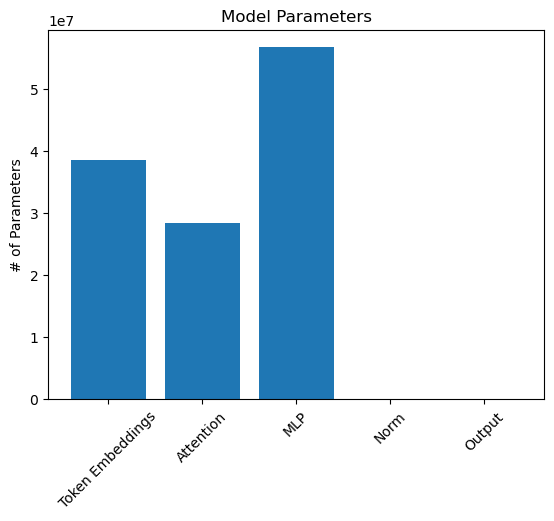

Token Embeddings               38,597,376      31.24%
Attention                      28,311,552      22.91%
MLP                            56,623,104      45.83%
Norm                               19,200       0.02%
Output                                  0       0.00%
Total parameters: 123,551,232


In [16]:
# Some working statistics

# Model
vocabulary_size = 50257
embedding_dimensions = 768
num_attention_heads = 12
num_hidden_layers = 12
feed_forward_ratio = 4

import matplotlib.pyplot as plt

parameter_counts = {
    "Token Embeddings": vocabulary_size * embedding_dimensions,
    "Attention": (
        embedding_dimensions * 3 * embedding_dimensions + embedding_dimensions**2
    ) * num_hidden_layers,
    "MLP": (
        embedding_dimensions * feed_forward_ratio * embedding_dimensions * 2
    ) * num_hidden_layers,
    "Norm": embedding_dimensions * 2 * num_hidden_layers + embedding_dimensions,
    "Output": 0, # We share the embedding weights
}

plt.bar(parameter_counts.keys(), parameter_counts.values())

plt.title("Model Parameters")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)

plt.show()

total_parameter_count = sum(parameter_counts.values())

for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")


print(f"Total parameters: {total_parameter_count:,}")

To get an idea of the "shape" of our neural network we'll look at the ratio of embeding dimensions to number of layers. Generally, a aspect ratio betweem 50 and 100 is considered optimal according to certain scaling laws (Kaplan et al., 2020).

In [17]:
aspect_ratio = embedding_dimensions / num_hidden_layers

print(f"Network has an aspect ratio of {aspect_ratio:.2f}")

Network has an aspect ratio of 64.00


We can do the same abalysis for the ratio of embedding dimensions to the number of attention heads. A ratio between 20 and 80 is considered optimal according to the same paper.

In [18]:
heads_ratio = embedding_dimensions / num_attention_heads

print(f"Heads ratio is {heads_ratio:.2f}")

Heads ratio is 64.00


Next, we'll estimate the size of the model in memory and on disk. Note that this does not include any intermediate variables that get memorized during training such as activations, gradients, optimizer state, and temporary buffers. Actual memory consumption will likely be much higher. 

In [19]:
bytes_per_parameter = 32 // 8  # Assuming 32-bit floating point

total_bytes = total_parameter_count * bytes_per_parameter

total_gigabytes = total_bytes / 1e9

print(f"Total gigabytes: {total_gigabytes:,.2f}G")

Total gigabytes: 0.49G


We can estimate the optimal number of training tokens using the Chinchilla scaling laws given the number of parameters

In [20]:
num_training_tokens = 20 * total_parameter_count
samples_per_epoch = 512
tokens_per_sample = 2048
num_epochs_required = round(
    num_training_tokens / (samples_per_epoch * tokens_per_sample)
)
print(f"Optimal training tokens: {num_training_tokens:,}")

print(f"Epochs required: {num_epochs_required:,}", end="\n\n")

Optimal training tokens: 2,471,024,640
Epochs required: 2,357



Next, we'll estimate the maximum number of floating point operations (FLOPs) required to perform a full forward pass of the nwtwork on a single sample.

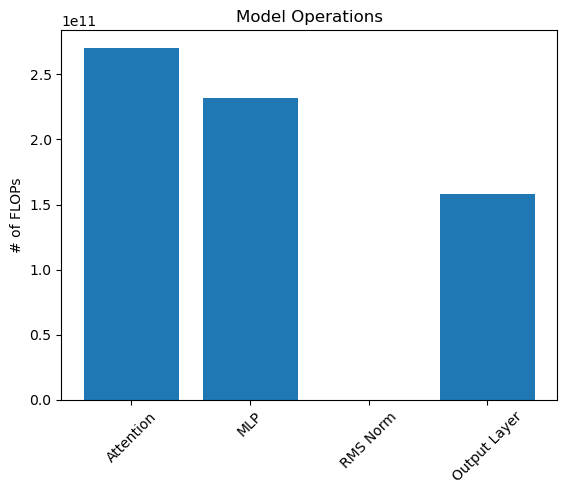

Attention                 270,582,939,648      40.96%
MLP                       231,928,455,168      35.11%
RMS Norm                           69,888       0.00%
Output Layer              158,094,852,096      23.93%


Total forward FLOPs: 660,606,316,800


In [21]:
ops_per_matmul = 2 # Multiply + accumulate (MAC)
# ops_per_activation = 5 # Assuming SiLU
ops_per_activation = 6 # Assuming GeLU
ops_per_rms_norm = 7 # y = x / sqrt(sum(x^2) / n + epsilon) * gamma
head_dimensions = embedding_dimensions // num_attention_heads

# K, Q, V projections
attention = (
    ops_per_matmul
    * tokens_per_sample
    * (embedding_dimensions * 3 * embedding_dimensions)
)

# Attention logits
attention += (
    ops_per_matmul * tokens_per_sample * tokens_per_sample * embedding_dimensions
)

# Reductions
attention += (
    ops_per_matmul
    * num_attention_heads
    * (tokens_per_sample * tokens_per_sample * head_dimensions)
)

# Output projection
attention += ops_per_matmul * tokens_per_sample * embedding_dimensions**2

attention *= num_hidden_layers

# Linear transformations
mlp = (
    ops_per_matmul
    * tokens_per_sample
    * (embedding_dimensions * (4 * embedding_dimensions))
)
mlp += (
    ops_per_matmul
    * tokens_per_sample
    * ((4 * embedding_dimensions) * embedding_dimensions)
)

# Non-linear activations
mlp += ops_per_activation * (4 * embedding_dimensions)

mlp *= num_hidden_layers

rms_norm = ops_per_rms_norm * embedding_dimensions * (num_hidden_layers + 1)

output_layer = (
    ops_per_matmul * tokens_per_sample * embedding_dimensions * vocabulary_size
)

flops = {
    "Attention": attention,
    "MLP": mlp,
    "RMS Norm": rms_norm,
    "Output Layer": output_layer,
}

plt.bar(flops.keys(), flops.values())

plt.title("Model Operations")
plt.ylabel("# of FLOPs")
plt.xticks(rotation=45)

plt.show()

total_forward_flops = sum(flops.values())

for name, count in flops.items():
    print(f"{name:20s} {count:20,d} {count / total_forward_flops * 100:10.2f}%")

print("\n")

print(f"Total forward FLOPs: {total_forward_flops:,}")

Next, we'll estimate the number of FLOPs for the backward pass. For this we use a simple heuristic of 2x the forward pass

In [22]:
total_backward_flops = 2 * total_forward_flops

print(f"Total backward FLOPs: {total_backward_flops:,}")

Total backward FLOPs: 1,321,212,633,600


We'll do the same for the total FLOPs per roundtrip.

In [23]:
total_roundtrip_flops = total_forward_flops + total_backward_flops

print(f"Total roundtrip FLOPs: {total_roundtrip_flops:,}")

Total roundtrip FLOPs: 1,981,818,950,400


Now, let's estimate the number of FLOPs using the method in the PaLM paper by Chowdhery, et al. Then, we'll compare the PaLM estimation with our own as a sanity check.

In [24]:
palm_flops_per_token = (
    6 * total_parameter_count
    + 12 * num_hidden_layers * num_attention_heads * head_dimensions * tokens_per_sample
)

total_palm_flops = palm_flops_per_token * tokens_per_sample

print(f"Total PaLM FLOPs: {total_palm_flops:,}")

Total PaLM FLOPs: 1,982,054,006,784


The two estimates are pretty close so let's proceed.

Finally, let's estimate how long it would take to train over the optimal number of tokens given some common Nvidia Ampere generation GPU hardware configurations. Note that these results shown here are a theoretical scenario and do not factor in additional overhead such as activation checkpointing or network latency.

In [25]:
from dataclasses import dataclass


@dataclass
class Device:
    name: str
    advertised_flops: float
    mfu: float

    @property
    def actual_flops(self) -> float:
        return self.mfu * self.advertised_flops


devices = [
    Device("RTX A2000", 63.9e12, 0.17),
    Device("RTX A4000", 153.4e12, 0.19),
    Device("RTX 3090", 285.5e12, 0.23),
    Device("A100 SXM", 624.0e12, 0.37),
    Device("HGX A100", 4992e12, 0.30),
]

for device in devices:
    seconds_per_epoch = samples_per_epoch * total_roundtrip_flops / device.actual_flops

    days_required = num_epochs_required * seconds_per_epoch / 60 / 60 / 24

    print(
        f"{device.name}: {seconds_per_epoch:.2f} seconds/epoch, {days_required:,.2f} days required"
    )

RTX A2000: 93.41 seconds/epoch, 2.55 days required
RTX A4000: 34.81 seconds/epoch, 0.95 days required
RTX 3090: 15.45 seconds/epoch, 0.42 days required
A100 SXM: 4.39 seconds/epoch, 0.12 days required
HGX A100: 0.68 seconds/epoch, 0.02 days required
